In [4]:
import pandas as pd
import numpy as np
import gzip
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
# !pip install xgboost 
# install to use

In [10]:
current_dir = r"I:\My Drive\MATH 1130 - MATH 2130\MATH 2130\midterm - final"
zip_file_path = os.path.join(current_dir, "mimic-iv-2.2.zip")

# Function to read a specific file from the ZIP without extracting everything
def loading(file_name):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        with zip_ref.open(file_name) as gz_file:
            df = pd.read_csv(gz_file, compression='gzip')
    return df



In [12]:
# filter data that have spinal cord word in their icd code

# spinal= d_icd_diagnoses[d_icd_diagnoses['long_title'].str.contains('spinal cord', case=False, na=False)]
# spinal_code=spinal['icd_code'].to_list()
# print(f' the number of icd code that include spinal cord {len(spinal['icd_code'].to_list())}')

# codes_total2 = spinal_cord_v10+spinal_cord_v9+spinal_code
# filtered_data2 = diagnoses_icd[diagnoses_icd['icd_code'].isin(codes_total2)]
# # len(codes_total2)
# # len(filtered_data2['icd_code'].unique())
# filtered_data2.shape


In [14]:
#this is all the code of patients who have spinal cord related injures
diagnoses_icd = loading('mimic-iv-2.2/hosp/diagnoses_icd.csv.gz')

diagnoses_icd['icd_code'] = diagnoses_icd['icd_code'].str.strip()
diagnoses_icd['icd_code'] = diagnoses_icd['icd_code'].str.upper()


spinal_cord_v9= ["80600", "80601", "80602", "80603", "80604", "80605", "80606", "80607", "80608", "80609"]
spinal_cord_v10 = ["S12000A", "S12001A", "S14101A", "S12100A", "S12101A", "S14102A", "S12200A", "S12201A", "S14103A",
                  "S12300A", "S12301A", "S14104A",
                  "S14111A", "S14112A", "S14113A", "S14114A",
                   "S14131A", "S14132A", "S14133A", "S14134A",
                   "S14121A", "S14122A", "S14123A", "S14124A",
                   "S14151A", "S14152A", "S14153A", "S14154A",
                   "S12400A", "S12401A", "S12500A", "S12501A", "S12600A", "S12601A",
                   "S14115A", "S14116A", "S14117A",
                   "S14125A", "S14126A", "S14127A", 
                   "S14135A", "S14136A", "S14137A",
                   "S14155A", "S14156A", "S14157A"
                  ]
codes_total1 = spinal_cord_v10+spinal_cord_v9
filtered_data1 = diagnoses_icd[diagnoses_icd['icd_code'].isin(codes_total1)]
print(filtered_data1.info())
#there are 603 unique patient but some of them have more than 1 diagnoses in term of spinal cord so 866 rows
print(filtered_data1['subject_id'].unique().shape)
filtered_data1


<class 'pandas.core.frame.DataFrame'>
Index: 866 entries, 5464 to 4750184
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subject_id   866 non-null    int64 
 1   hadm_id      866 non-null    int64 
 2   seq_num      866 non-null    int64 
 3   icd_code     866 non-null    object
 4   icd_version  866 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 40.6+ KB
None
(603,)


,subject_id,hadm_id,seq_num,icd_code,icd_version
5464,10010867,22429197,1,S12600A,10
5835,10011607,28165131,1,S12300A,10
7991,10014670,24563254,1,S12000A,10
14541,10030426,21721026,1,S12000A,10
26191,10055235,24749318,2,S14101A,10
...,...,...,...,...,...
4734996,19953811,29850814,1,80609,9
4743064,19970358,22717900,1,S12500A,10
4743570,19970947,28546800,1,80600,9
4743572,19970947,28546800,3,80605,9


In [15]:
#definition of icd code
diagnoses_icd_info = loading('mimic-iv-2.2/hosp/d_icd_diagnoses.csv.gz')


In [16]:
#this show all the number of patients who have spinal cord but also have other issues at the same time
a=diagnoses_icd[diagnoses_icd['subject_id'].isin(filtered_data1['subject_id'])]
print(a['subject_id'].unique().shape)
print(a['hadm_id'].unique().shape)
print(a['hadm_id'].shape)
# => there are 603 unique patients, 1561 unique admisison but have 20376 admisisons
# ( so 1 people can have multiple diagonoses)
a

(603,)
(1561,)
(20376,)


,subject_id,hadm_id,seq_num,icd_code,icd_version
5453,10010867,22196214,1,J90,10
5454,10010867,22196214,2,I272,10
5455,10010867,22196214,3,M25511,10
5456,10010867,22196214,4,Z981,10
5457,10010867,22196214,5,Z87820,10
...,...,...,...,...,...
4750207,19986810,26643055,24,Y846,10
4750208,19986810,26643055,25,Y92230,10
4750209,19986810,26643055,26,R339,10
4750210,19986810,26643055,27,K5900,10


In [525]:
#i then want to create a new column 'others_icd' that show all the diagnoses each patient have beside 
#having spinal core injuries and save it as a list for later use

# Filter diagnoses_icd for subject_id in filtered_data1 AND icd_code not in codes_total1
a = diagnoses_icd[diagnoses_icd['subject_id'].isin(\
    filtered_data1['subject_id']) &~a['icd_code'].isin(codes_total1)]


# grouped = a.groupby(['subject_id', 'hadm_id'])['icd_code'].agg(list).reset_index()

 # Aggregate all icd_code into a list per subject_id + hadm_id
icd_list= a.groupby(['subject_id', 'hadm_id'])['icd_code'].agg(list).reset_index()
icd_list.rename(columns={'icd_code': 'others_icd'}, inplace=True)
 
# then merge
grouped = a.merge(icd_list, on=['subject_id', 'hadm_id'], how='left')
grouped = grouped.drop_duplicates(subset=['subject_id', 'hadm_id'])
grouped.drop(columns=['icd_version','icd_code'])


,subject_id,hadm_id,seq_num,others_icd
0,10010867,22196214,1,"[J90, I272, M25511, Z981, Z87820, V8609XS, Y92..."
11,10010867,22429197,2,"[S271XXA, S066X0A, J9600, S240XXA, F05, S22049..."
36,10010867,22950920,1,"[S22059A, F329, S22069A, V499XXA, Y929, E669, ..."
48,10011607,23426764,1,"[49392, 51881, 4139, 4019, 29420, 2724, 2449, ..."
62,10011607,24673789,1,"[3510, 78079, 73300]"
...,...,...,...,...
19463,19970947,24944200,1,"[2761, 73300, 27652, 78701]"
19467,19970947,28242726,1,"[7820, 4019]"
19469,19970947,28546800,2,"[80620, E8809, E8490, 920, 73300, 78009]"
19475,19970947,29317918,1,"[7230, 7211, 9072, E9293, E8498, 7812, 73303, ..."


In [526]:
#this is our main df for the patient, we then use other given df to add infomation to this dataste

spinal_patients =filtered_data1.merge(diagnoses_icd_info[['icd_code', 'long_title']], 
                             on='icd_code',   how='left')

# Create a mapping from hadm_id to others_icd
hadm_to_icd = grouped.set_index('hadm_id')['others_icd']
hadm_to_icd
# # # Use map to assign the corresponding value to spinal_patients
spinal_patients['others_icd'] = spinal_patients['hadm_id'].map(hadm_to_icd)
spinal_patients

#we save this dataset into  'spinal_patients.csv'

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title,others_icd
0,10010867,22429197,1,S12600A,10,Unspecified displaced fracture of seventh cerv...,"[S271XXA, S066X0A, J9600, S240XXA, F05, S22049..."
1,10011607,28165131,1,S12300A,10,Unspecified displaced fracture of fourth cervi...,"[S0990XA, S0512XA, W1809XA, Y929, J45909, I10,..."
2,10014670,24563254,1,S12000A,10,Unspecified displaced fracture of first cervic...,"[I4891, W19XXXA, Y929, Z7901, Z8673, I10]"
3,10030426,21721026,1,S12000A,10,Unspecified displaced fracture of first cervic...,"[S40011A, E119, I10, E785, R55, W1830XA, Y92002]"
4,10055235,24749318,2,S14101A,10,Unspecified injury at C1 level of cervical spi...,"[S066X9A, S12091A, F10239, I67848, R291, E871,..."
...,...,...,...,...,...,...,...
861,19953811,29850814,1,80609,9,Closed fracture of C5-C7 level with other spec...,"[80624, 5990, E882, 78720]"
862,19970358,22717900,1,S12500A,10,Unspecified displaced fracture of sixth cervic...,"[G92, E222, C259, E1165, D6862, S3219XA, N390,..."
863,19970947,28546800,1,80600,9,Closed fracture of C1-C4 level with unspecifie...,"[80620, E8809, E8490, 920, 73300, 78009]"
864,19970947,28546800,3,80605,9,Closed fracture of C5-C7 level with unspecifie...,"[80620, E8809, E8490, 920, 73300, 78009]"


In [474]:
# Drop duplicates based on 'icd_code' and keep the first occurrence
unique_icd = spinal_patients.drop_duplicates(subset='icd_code')

# Create a dictionary: {icd_code: long_title}
icd_dict = dict(zip(unique_icd['icd_code'], unique_icd['long_title']))
print(len(icd_dict))
icd_dict

49


{'S12600A': 'Unspecified displaced fracture of seventh cervical vertebra, initial encounter for closed fracture',
 'S12300A': 'Unspecified displaced fracture of fourth cervical vertebra, initial encounter for closed fracture',
 'S12000A': 'Unspecified displaced fracture of first cervical vertebra, initial encounter for closed fracture',
 'S14101A': 'Unspecified injury at C1 level of cervical spinal cord, initial encounter',
 'S12001A': 'Unspecified nondisplaced fracture of first cervical vertebra, initial encounter for closed fracture',
 'S14125A': 'Central cord syndrome at C5 level of cervical spinal cord, initial encounter',
 'S14126A': 'Central cord syndrome at C6 level of cervical spinal cord, initial encounter',
 'S12500A': 'Unspecified displaced fracture of sixth cervical vertebra, initial encounter for closed fracture',
 'S12201A': 'Unspecified nondisplaced fracture of third cervical vertebra, initial encounter for closed fracture',
 'S12301A': 'Unspecified nondisplaced fracture

In [476]:
grouped_icd_dict = {
    # C1–C4 Fracture
    'S12000A': 'C1-C4 Fracture',
    'S12100A': 'C1-C4 Fracture',
    'S12200A': 'C1-C4 Fracture',
    'S12300A': 'C1-C4 Fracture',
    'S12400A': 'C1-C4 Fracture',
    
    # C1–C4 Nondisplaced Fracture
    'S12001A': 'C1-C4 Nondisplaced Fracture',
    'S12101A': 'C1-C4 Nondisplaced Fracture',
    'S12201A': 'C1-C4 Nondisplaced Fracture',
    'S12301A': 'C1-C4 Nondisplaced Fracture',
    'S12401A': 'C1-C4 Nondisplaced Fracture',
    
    # C5–C7 Fracture
    'S12500A': 'C5-C7 Fracture',
    'S12600A': 'C5-C7 Fracture',
    
    # C5–C7 Nondisplaced Fracture
    'S12501A': 'C5-C7 Nondisplaced Fracture',
    'S12601A': 'C5-C7 Nondisplaced Fracture',
    
    # Unspecified Spinal Cord Injury
    'S14101A': 'Spinal Cord Injury C1',
    'S14102A': 'Spinal Cord Injury C2',
    'S14103A': 'Spinal Cord Injury C3',
    'S14104A': 'Spinal Cord Injury C4',
    
    # Central Cord Syndrome
    'S14122A': 'Central Cord Syndrome',
    'S14123A': 'Central Cord Syndrome',
    'S14124A': 'Central Cord Syndrome',
    'S14125A': 'Central Cord Syndrome',
    'S14126A': 'Central Cord Syndrome',
    'S14127A': 'Central Cord Syndrome',
    '80603': 'Central Cord Syndrome',
    '80608': 'Central Cord Syndrome',
    
    # Anterior Cord Syndrome
    'S14132A': 'Anterior Cord Syndrome',
    'S14135A': 'Anterior Cord Syndrome',
    '80602': 'Anterior Cord Syndrome',
    '80607': 'Anterior Cord Syndrome',
    
    # Complete Lesion
    'S14111A': 'Complete Lesion',
    'S14112A': 'Complete Lesion',
    'S14113A': 'Complete Lesion',
    'S14114A': 'Complete Lesion',
    'S14115A': 'Complete Lesion',
    'S14116A': 'Complete Lesion',
    'S14117A': 'Complete Lesion',
    '80601': 'Complete Lesion',
    '80606': 'Complete Lesion',
    
    # Other Incomplete Lesion
    'S14152A': 'Other Incomplete Lesion',
    'S14153A': 'Other Incomplete Lesion',
    'S14154A': 'Other Incomplete Lesion',
    'S14155A': 'Other Incomplete Lesion',
    'S14156A': 'Other Incomplete Lesion',
    'S14157A': 'Other Incomplete Lesion',
    
    # Other Closed Fractures
    '80600': 'Closed Fracture C1-C4 w/ Injury',
    '80604': 'Closed Fracture C1-C4 w/ Injury',
    '80605': 'Closed Fracture C5-C7 w/ Injury',
    '80609': 'Closed Fracture C5-C7 w/ Injury'}
# Assuming your column of main ICD code is 'icd_code'
spinal_patients['icd_group'] = spinal_patients['icd_code'].map(grouped_icd_dict)
spinal_patients

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title,icd_group
0,10010867,22429197,1,S12600A,10,Unspecified displaced fracture of seventh cerv...,C5-C7 Fracture
1,10011607,28165131,1,S12300A,10,Unspecified displaced fracture of fourth cervi...,C1-C4 Fracture
2,10014670,24563254,1,S12000A,10,Unspecified displaced fracture of first cervic...,C1-C4 Fracture
3,10030426,21721026,1,S12000A,10,Unspecified displaced fracture of first cervic...,C1-C4 Fracture
4,10055235,24749318,2,S14101A,10,Unspecified injury at C1 level of cervical spi...,Spinal Cord Injury C1
...,...,...,...,...,...,...,...
861,19953811,29850814,1,80609,9,Closed fracture of C5-C7 level with other spec...,Closed Fracture C5-C7 w/ Injury
862,19970358,22717900,1,S12500A,10,Unspecified displaced fracture of sixth cervic...,C5-C7 Fracture
863,19970947,28546800,1,80600,9,Closed fracture of C1-C4 level with unspecifie...,Closed Fracture C1-C4 w/ Injury
864,19970947,28546800,3,80605,9,Closed fracture of C5-C7 level with unspecifie...,Closed Fracture C5-C7 w/ Injury


In [478]:
patients =loading("mimic-iv-2.2/hosp/patients.csv.gz")
patients1 = patients[patients['subject_id'].isin(filtered_data1['subject_id'])]
print(patients1.info())
patients1 = patients1.sort_values(by='anchor_age')
patients1

<class 'pandas.core.frame.DataFrame'>
Index: 603 entries, 335 to 299320
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subject_id         603 non-null    int64 
 1   gender             603 non-null    object
 2   anchor_age         603 non-null    int64 
 3   anchor_year        603 non-null    int64 
 4   anchor_year_group  603 non-null    object
 5   dod                137 non-null    object
dtypes: int64(3), object(3)
memory usage: 33.0+ KB
None


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
170253,15690176,F,19,2148,2017 - 2019,NaN
231111,17716301,M,19,2134,2014 - 2016,NaN
127529,14272070,F,19,2181,2017 - 2019,NaN
27405,10921950,F,20,2135,2017 - 2019,NaN
97828,13277450,F,20,2134,2017 - 2019,NaN
...,...,...,...,...,...,...
205509,16865976,M,91,2168,2014 - 2016,NaN
47608,11598290,M,91,2116,2017 - 2019,NaN
9190,10307666,F,91,2164,2014 - 2016,2164-07-24
245922,18208434,F,91,2136,2008 - 2010,2144-03-01


In [479]:
admissions =loading('mimic-iv-2.2/hosp/admissions.csv.gz')
admissions1 = admissions[admissions['subject_id'].isin(filtered_data1['subject_id'])]
print(admissions1.info())
admissions1
# admissions1[admissions1['deathtime'].notna()]
# admissions1[admissions1['hospital_expire_flag']==1]

<class 'pandas.core.frame.DataFrame'>
Index: 1566 entries, 489 to 430674
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   subject_id            1566 non-null   int64 
 1   hadm_id               1566 non-null   int64 
 2   admittime             1566 non-null   object
 3   dischtime             1566 non-null   object
 4   deathtime             63 non-null     object
 5   admission_type        1566 non-null   object
 6   admit_provider_id     1566 non-null   object
 7   admission_location    1566 non-null   object
 8   discharge_location    1036 non-null   object
 9   insurance             1566 non-null   object
 10  language              1566 non-null   object
 11  marital_status        1477 non-null   object
 12  race                  1566 non-null   object
 13  edregtime             1382 non-null   object
 14  edouttime             1382 non-null   object
 15  hospital_expire_flag  1566 non-null   i

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
489,10010867,22196214,2148-03-07 23:30:00,2148-03-13 15:50:00,NaN,OBSERVATION ADMIT,P233F6,EMERGENCY ROOM,REHAB,Other,ENGLISH,DIVORCED,WHITE - BRAZILIAN,2148-03-07 18:21:00,2148-03-08 00:50:00,0
490,10010867,22429197,2147-12-30 08:40:00,2148-01-11 17:55:00,NaN,EW EMER.,P3417E,EMERGENCY ROOM,REHAB,Other,ENGLISH,SINGLE,WHITE - BRAZILIAN,2147-12-30 06:45:00,2147-12-30 09:33:00,0
491,10010867,22950920,2148-01-25 22:58:00,2148-01-30 11:23:00,NaN,OBSERVATION ADMIT,P39FGY,EMERGENCY ROOM,REHAB,Other,ENGLISH,DIVORCED,WHITE - BRAZILIAN,2148-01-25 18:46:00,2148-01-26 01:27:00,0
518,10011607,23426764,2184-04-26 23:06:00,2184-04-30 17:02:00,NaN,EW EMER.,P20DGX,EMERGENCY ROOM,HOME HEALTH CARE,Other,?,DIVORCED,HISPANIC/LATINO - PUERTO RICAN,2184-04-26 15:27:00,2184-04-27 01:09:00,0
519,10011607,24673789,2182-01-11 23:49:00,2182-01-12 13:16:00,NaN,EU OBSERVATION,P53TMV,EMERGENCY ROOM,NaN,Other,?,SINGLE,HISPANIC/LATINO - PUERTO RICAN,2182-01-11 19:44:00,2182-01-12 13:16:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430036,19970947,24944200,2183-08-12 16:36:00,2183-08-13 15:30:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,REHAB,Medicare,ENGLISH,MARRIED,WHITE,2183-08-12 10:52:00,2183-08-12 17:42:00,0
430037,19970947,28242726,2183-09-24 15:28:00,2183-09-24 16:40:00,NaN,EU OBSERVATION,P6683B,EMERGENCY ROOM,NaN,Medicare,ENGLISH,MARRIED,WHITE,2183-09-24 10:31:00,2183-09-24 16:40:00,0
430038,19970947,28546800,2183-08-04 10:59:00,2183-08-06 16:45:00,NaN,EW EMER.,P01LRQ,EMERGENCY ROOM,REHAB,Medicare,ENGLISH,MARRIED,WHITE,2183-08-04 04:15:00,2183-08-04 13:05:00,0
430039,19970947,29317918,2183-09-30 17:11:00,2183-10-02 13:20:00,NaN,URGENT,P01LRQ,TRANSFER FROM SKILLED NURSING FACILITY,SKILLED NURSING FACILITY,Medicare,ENGLISH,MARRIED,WHITE,NaN,NaN,0


THIS IS THE MAIN DATAFRAME IN THE HOSP SECTION, use this to filter the icu section

In [482]:
merged_data = pd.merge(patients1, admissions1, on='subject_id', how='left')
merged_data = merged_data.drop(columns=['subject_id' ,'admit_provider_id', 'insurance', 'language','hospital_expire_flag','deathtime'])

 

merged_data
#from this, I will merge it with spinal_patients

spinal_patients = spinal_patients.merge(  merged_data,  on='hadm_id',  how='left')
 
spinal_patients.drop(columns=['icd_version','discharge_location',\
                    'discharge_location','admission_location','admittime', 'dischtime'])
spinal_patients

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title,icd_group,gender,anchor_age,anchor_year,anchor_year_group,dod,admittime,dischtime,admission_type,admission_location,discharge_location,marital_status,race,edregtime,edouttime
0,10010867,22429197,1,S12600A,10,Unspecified displaced fracture of seventh cerv...,C5-C7 Fracture,F,28,2147,2014 - 2016,NaN,2147-12-30 08:40:00,2148-01-11 17:55:00,EW EMER.,EMERGENCY ROOM,REHAB,SINGLE,WHITE - BRAZILIAN,2147-12-30 06:45:00,2147-12-30 09:33:00
1,10011607,28165131,1,S12300A,10,Unspecified displaced fracture of fourth cervi...,C1-C4 Fracture,F,73,2181,2011 - 2013,NaN,2185-03-17 18:12:00,2185-03-19 17:05:00,EU OBSERVATION,EMERGENCY ROOM,NaN,DIVORCED,HISPANIC/LATINO - PUERTO RICAN,2185-03-17 12:12:00,2185-03-19 17:05:00
2,10014670,24563254,1,S12000A,10,Unspecified displaced fracture of first cervic...,C1-C4 Fracture,F,89,2187,2014 - 2016,NaN,2187-05-09 01:12:00,2187-05-11 16:20:00,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,MARRIED,WHITE,2187-05-08 18:25:00,2187-05-09 02:10:00
3,10030426,21721026,1,S12000A,10,Unspecified displaced fracture of first cervic...,C1-C4 Fracture,M,67,2136,2017 - 2019,NaN,2136-01-02 04:43:00,2136-01-02 12:53:00,EU OBSERVATION,TRANSFER FROM HOSPITAL,NaN,MARRIED,OTHER,2136-01-01 16:40:00,2136-01-02 12:53:00
4,10055235,24749318,2,S14101A,10,Unspecified injury at C1 level of cervical spi...,Spinal Cord Injury C1,M,31,2175,2017 - 2019,NaN,2175-03-11 02:59:00,2175-03-30 15:25:00,OBSERVATION ADMIT,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,SINGLE,WHITE,2175-03-10 14:23:00,2175-03-11 03:27:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861,19953811,29850814,1,80609,9,Closed fracture of C5-C7 level with other spec...,Closed Fracture C5-C7 w/ Injury,M,47,2115,2011 - 2013,NaN,2115-02-23 22:39:00,2115-03-07 12:53:00,EW EMER.,EMERGENCY ROOM,HOME,MARRIED,WHITE,2115-02-23 13:39:00,2115-02-24 00:39:00
862,19970358,22717900,1,S12500A,10,Unspecified displaced fracture of sixth cervic...,C5-C7 Fracture,F,74,2137,2014 - 2016,NaN,2137-02-18 00:42:00,2137-02-22 15:40:00,OBSERVATION ADMIT,EMERGENCY ROOM,SKILLED NURSING FACILITY,MARRIED,BLACK/AFRICAN AMERICAN,2137-02-17 20:39:00,2137-02-18 02:59:00
863,19970947,28546800,1,80600,9,Closed fracture of C1-C4 level with unspecifie...,Closed Fracture C1-C4 w/ Injury,F,74,2183,2011 - 2013,NaN,2183-08-04 10:59:00,2183-08-06 16:45:00,EW EMER.,EMERGENCY ROOM,REHAB,MARRIED,WHITE,2183-08-04 04:15:00,2183-08-04 13:05:00
864,19970947,28546800,3,80605,9,Closed fracture of C5-C7 level with unspecifie...,Closed Fracture C5-C7 w/ Injury,F,74,2183,2011 - 2013,NaN,2183-08-04 10:59:00,2183-08-06 16:45:00,EW EMER.,EMERGENCY ROOM,REHAB,MARRIED,WHITE,2183-08-04 04:15:00,2183-08-04 13:05:00


In [432]:
marital_status_counts = admissions1['admission_type'].unique()
print(marital_status_counts)

['OBSERVATION ADMIT' 'EW EMER.' 'EU OBSERVATION' 'URGENT'
 'AMBULATORY OBSERVATION' 'DIRECT OBSERVATION'
 'SURGICAL SAME DAY ADMISSION' 'DIRECT EMER.' 'ELECTIVE']


In [435]:
procedures_icd =loading('mimic-iv-2.2/hosp/procedures_icd.csv.gz')
procedures_icd1 = procedures_icd[procedures_icd['subject_id'].isin(filtered_data1['subject_id'])]
print(procedures_icd1.info())
procedures_icd1.head(60)

<class 'pandas.core.frame.DataFrame'>
Index: 3452 entries, 710 to 667225
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subject_id   3452 non-null   int64 
 1   hadm_id      3452 non-null   int64 
 2   seq_num      3452 non-null   int64 
 3   chartdate    3452 non-null   object
 4   icd_code     3452 non-null   object
 5   icd_version  3452 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 188.8+ KB
None


,subject_id,hadm_id,seq_num,chartdate,icd_code,icd_version
710,10010867,22196214,1,2148-03-09,0W9930Z,10
711,10010867,22429197,1,2147-12-31,0RG10A0,10
712,10010867,22429197,2,2148-01-02,0RG1071,10
713,10010867,22429197,3,2147-12-31,0RB30ZZ,10
714,10010867,22429197,4,2148-01-01,0BJ08ZZ,10
715,10010867,22429197,5,2147-12-30,5A1955Z,10
716,10010867,22429197,6,2148-01-04,0B9B8ZX,10
717,10010867,22429197,7,2148-01-04,0B948ZX,10
718,10010867,22429197,8,2148-01-04,0B988ZX,10
719,10010867,22429197,9,2148-01-01,3E0G76Z,10


In [573]:
#before filtering
print(f'{len(admissions)} stays in the hospital')
print(f'{len(admissions.subject_id.unique())} unique patients in the hospital')
print(f'{len(icu_stay)} ICU stays')
print(f'{len(icu_stay.subject_id.unique())} unique icu patient')
print(f'{len(icu_stay.hadm_id.unique())} unique icu patient')
# unique patient with spinal cord injury at the neck
# len(filtered_data['subject_id'].unique()) 

431231 stays in the hospital
180733 unique patients in the hospital
73181 ICU stays
50920 unique icu patient
66239 unique icu patient


In [575]:
#after filtering
print(f'{len(admissions1)} stays in the hospital')
print(f'{len(admissions1.subject_id.unique())} unique patients in the hospital')
print(f'{len(icu_stay1)} ICU stays')
print(f'{len(icu_stay1.subject_id.unique())} unique icu patient')
print(f'{len(icu_stay1.hadm_id.unique())} unique icu patient')

1566 stays in the hospital
603 unique patients in the hospital
460 ICU stays
262 unique icu patient
264 unique icu patient


In [491]:
# spinal_patients.to_csv('spinal_patients.csv', index=False)
spinal_patients=pd.read_csv('spinal_patients.csv')
icu_stay=loading("mimic-iv-2.2/icu/icustays.csv.gz")
icu_stay1 = icu_stay[icu_stay['hadm_id'].isin(filtered_data1['hadm_id'])]



icu_stay1 = icu_stay1.merge(spinal_patients,  on=['hadm_id','subject_id'],  how='left')
 
icu_stay1['edregtime'] = pd.to_datetime(icu_stay1['edregtime'])
icu_stay1['edouttime'] = pd.to_datetime(icu_stay1['edouttime'])

icu_stay1['ed_duration_hours'] = (icu_stay1['edouttime'] - icu_stay1['edregtime']).dt.total_seconds() / 3600


icu_stay1=icu_stay1.drop(columns=['first_careunit','last_careunit','intime','stay_id',
                                  'icd_version','outtime','seq_num','discharge_location','dod',
                                  'admission_location','admittime', 'dischtime',
                                  'edregtime','edouttime'])

print(icu_stay1.info())

icu_stay1['hadm_id'].unique().shape
icu_stay1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   subject_id         460 non-null    int64  
 1   hadm_id            460 non-null    int64  
 2   los                460 non-null    float64
 3   icd_code           460 non-null    object 
 4   long_title         460 non-null    object 
 5   icd_group          460 non-null    object 
 6   gender             460 non-null    object 
 7   anchor_age         460 non-null    int64  
 8   anchor_year        460 non-null    int64  
 9   anchor_year_group  460 non-null    object 
 10  admission_type     460 non-null    object 
 11  marital_status     327 non-null    object 
 12  race               460 non-null    object 
 13  ed_duration_hours  434 non-null    float64
dtypes: float64(2), int64(4), object(8)
memory usage: 50.4+ KB
None


,subject_id,hadm_id,los,icd_code,long_title,icd_group,gender,anchor_age,anchor_year,anchor_year_group,admission_type,marital_status,race,ed_duration_hours
0,10010867,22429197,9.362049,S12600A,Unspecified displaced fracture of seventh cerv...,C5-C7 Fracture,F,28,2147,2014 - 2016,EW EMER.,SINGLE,WHITE - BRAZILIAN,2.800000
1,10055235,24749318,19.141736,S14101A,Unspecified injury at C1 level of cervical spi...,Spinal Cord Injury C1,M,31,2175,2017 - 2019,OBSERVATION ADMIT,SINGLE,WHITE,13.066667
2,10058575,26633991,19.200208,S12001A,Unspecified nondisplaced fracture of first cer...,C1-C4 Nondisplaced Fracture,F,55,2156,2014 - 2016,OBSERVATION ADMIT,DIVORCED,WHITE,3.183333
3,10064390,23328727,6.130926,S14125A,Central cord syndrome at C5 level of cervical ...,Central Cord Syndrome,M,74,2137,2014 - 2016,EW EMER.,MARRIED,UNKNOWN,3.666667
4,10064390,23328727,6.130926,S14126A,Central cord syndrome at C6 level of cervical ...,Central Cord Syndrome,M,74,2137,2014 - 2016,EW EMER.,MARRIED,UNKNOWN,3.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,19911351,25037898,1.719653,S12400A,Unspecified displaced fracture of fifth cervic...,C1-C4 Fracture,M,87,2139,2017 - 2019,OBSERVATION ADMIT,NaN,UNKNOWN,2.483333
456,19911351,25037898,1.719653,S12500A,Unspecified displaced fracture of sixth cervic...,C5-C7 Fracture,M,87,2139,2017 - 2019,OBSERVATION ADMIT,NaN,UNKNOWN,2.483333
457,19911351,25037898,1.719653,S12600A,Unspecified displaced fracture of seventh cerv...,C5-C7 Fracture,M,87,2139,2017 - 2019,OBSERVATION ADMIT,NaN,UNKNOWN,2.483333
458,19970947,28546800,1.336933,80600,Closed fracture of C1-C4 level with unspecifie...,Closed Fracture C1-C4 w/ Injury,F,74,2183,2011 - 2013,EW EMER.,MARRIED,WHITE,8.833333


#### ANALYSIS FOR ADMISSION ***** 

In [494]:
unique_admission_icu = icu_stay1.drop_duplicates(subset='hadm_id')
unique_admission_icu

,subject_id,hadm_id,los,icd_code,long_title,icd_group,gender,anchor_age,anchor_year,anchor_year_group,admission_type,marital_status,race,ed_duration_hours
0,10010867,22429197,9.362049,S12600A,Unspecified displaced fracture of seventh cerv...,C5-C7 Fracture,F,28,2147,2014 - 2016,EW EMER.,SINGLE,WHITE - BRAZILIAN,2.800000
1,10055235,24749318,19.141736,S14101A,Unspecified injury at C1 level of cervical spi...,Spinal Cord Injury C1,M,31,2175,2017 - 2019,OBSERVATION ADMIT,SINGLE,WHITE,13.066667
2,10058575,26633991,19.200208,S12001A,Unspecified nondisplaced fracture of first cer...,C1-C4 Nondisplaced Fracture,F,55,2156,2014 - 2016,OBSERVATION ADMIT,DIVORCED,WHITE,3.183333
3,10064390,23328727,6.130926,S14125A,Central cord syndrome at C5 level of cervical ...,Central Cord Syndrome,M,74,2137,2014 - 2016,EW EMER.,MARRIED,UNKNOWN,3.666667
5,10149067,27304639,1.442708,S14123A,Central cord syndrome at C3 level of cervical ...,Central Cord Syndrome,F,62,2183,2017 - 2019,EW EMER.,SINGLE,BLACK/AFRICAN AMERICAN,52.016667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,19739493,23894396,4.686898,80600,Closed fracture of C1-C4 level with unspecifie...,Closed Fracture C1-C4 w/ Injury,M,23,2172,2014 - 2016,EW EMER.,NaN,UNKNOWN,2.600000
438,19752825,25712095,4.001019,80604,Closed fracture of C1-C4 level with other spec...,Closed Fracture C1-C4 w/ Injury,F,48,2112,2008 - 2010,EW EMER.,NaN,WHITE,1.966667
439,19788979,28470391,15.409421,80609,Closed fracture of C5-C7 level with other spec...,Closed Fracture C5-C7 w/ Injury,M,35,2113,2008 - 2010,EW EMER.,SINGLE,WHITE,2.000000
440,19911351,25037898,3.750405,S12300A,Unspecified displaced fracture of fourth cervi...,C1-C4 Fracture,M,87,2139,2017 - 2019,OBSERVATION ADMIT,NaN,UNKNOWN,2.483333


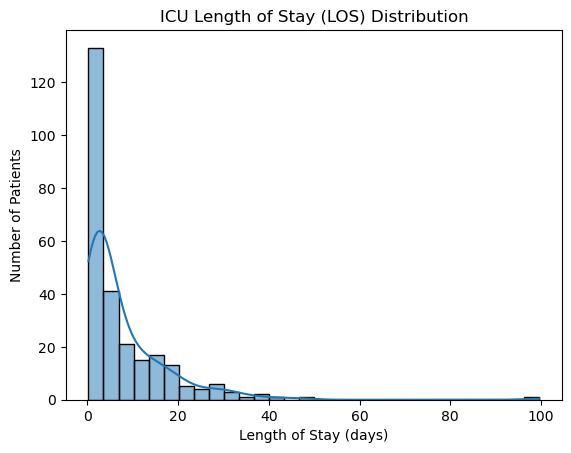

count    264.000000
mean       7.735766
std       10.243493
min        0.228808
25%        1.665828
50%        3.513582
75%       10.446508
max       99.638449
Name: los, dtype: float64

In [496]:
import seaborn as sns
import matplotlib.pyplot as plt
 
sns.histplot(unique_admission_icu['los'], bins=30, kde=True)
plt.title('ICU Length of Stay (LOS) Distribution')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Number of Patients')
plt.show()

unique_admission_icu['los'].describe()


Mean Length of Stay (LOS): The average LOS is 7.74 days, indicating that most patients stay in the ICU for a duration around this value.

Standard Deviation (STD): The standard deviation is 10.24 days, which suggests considerable variation in ICU stays, with some patients having a significantly shorter or longer stay compared to the average.

Minimum LOS: The shortest ICU stay recorded is 0.23 days, which could represent a short emergency intervention or a discharge soon after admission.

The distribution of LOS can provide insights into patient severity and healthcare resource usage. The relatively large standard deviation (10.24 days) and presence of a few extreme values (such as the maximum LOS of nearly 100 days) may indicate that certain patients require significantly longer ICU care than others. This is typical in cases involving severe or complex conditions that necessitate extended treatment and monitoring.

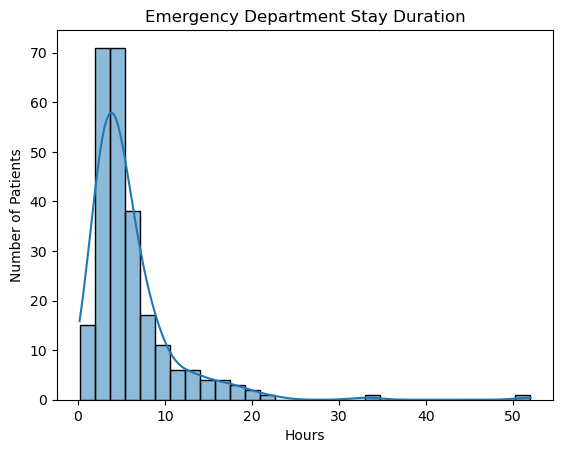

count    251.000000
mean       5.890239
std        5.171990
min        0.183333
25%        3.016667
50%        4.366667
75%        6.766667
max       52.016667
Name: ed_duration_hours, dtype: float64

In [499]:
sns.histplot(unique_admission_icu['ed_duration_hours'], bins=30, kde=True)
plt.title('Emergency Department Stay Duration')
plt.xlabel('Hours')
plt.ylabel('Number of Patients')
plt.show()
unique_admission_icu['ed_duration_hours'].describe()

Mean ED Duration: The average ED duration is 5.89 hours, which indicates that, on average, patients spend just under 6 hours in the emergency department.

Standard Deviation (STD): The standard deviation is 5.17 hours, suggesting that there is a considerable variation in the amount of time patients spend in the emergency department. This variability may be due to differences in the severity of cases or delays in treatment.

Minimum ED Duration: The shortest recorded ED duration is 0.18 hours (approximately 11 minutes). This could represent cases where patients quickly received care or had very minor conditions.A significant portion of patients (25%) are able to receive emergency care relatively quickly, with stays under 3 hours.

Half of the patients experience ED stays of less than 4.37 hours, indicating that a majority of patients experience relatively quick visits to the emergency department.

The maximum of 52.02 hours suggests rare instances where patients experienced delays in care or required complex interventions, possibly due to severe conditions or logistical challenges (e.g., waiting for specialized care or hospital admission).

In [515]:

#one hot coding for icd group
##### use it rather than individual icd code
pd.set_option('display.max_columns', None)  

df = unique_admission_icu
grouped = df.groupby(['subject_id', 'hadm_id'])['icd_group'].unique().reset_index()
icd_df = grouped['icd_group'].apply(lambda x: pd.Series(1, index=x)).fillna(0)

final_df = pd.concat([grouped[['subject_id', 'hadm_id']], icd_df], axis=1)

final_df


,subject_id,hadm_id,C5-C7 Fracture,Spinal Cord Injury C1,C1-C4 Nondisplaced Fracture,Central Cord Syndrome,Closed Fracture C1-C4 w/ Injury,Anterior Cord Syndrome,Closed Fracture C5-C7 w/ Injury,C5-C7 Nondisplaced Fracture,Complete Lesion,C1-C4 Fracture,Other Incomplete Lesion,Spinal Cord Injury C3,Spinal Cord Injury C4,Spinal Cord Injury C2
0,10010867,22429197,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10055235,24749318,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10058575,26633991,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10064390,23328727,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10149067,27304639,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,19739493,23894396,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
260,19752825,25712095,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
261,19788979,28470391,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
262,19911351,25037898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### ANALYSIS FOR PAtients *****

In [505]:
unique_patients_icu = icu_stay1.drop_duplicates(subset='subject_id')
unique_patients_icu

,subject_id,hadm_id,los,icd_code,long_title,icd_group,gender,anchor_age,anchor_year,anchor_year_group,admission_type,marital_status,race,ed_duration_hours
0,10010867,22429197,9.362049,S12600A,Unspecified displaced fracture of seventh cerv...,C5-C7 Fracture,F,28,2147,2014 - 2016,EW EMER.,SINGLE,WHITE - BRAZILIAN,2.800000
1,10055235,24749318,19.141736,S14101A,Unspecified injury at C1 level of cervical spi...,Spinal Cord Injury C1,M,31,2175,2017 - 2019,OBSERVATION ADMIT,SINGLE,WHITE,13.066667
2,10058575,26633991,19.200208,S12001A,Unspecified nondisplaced fracture of first cer...,C1-C4 Nondisplaced Fracture,F,55,2156,2014 - 2016,OBSERVATION ADMIT,DIVORCED,WHITE,3.183333
3,10064390,23328727,6.130926,S14125A,Central cord syndrome at C5 level of cervical ...,Central Cord Syndrome,M,74,2137,2014 - 2016,EW EMER.,MARRIED,UNKNOWN,3.666667
5,10149067,27304639,1.442708,S14123A,Central cord syndrome at C3 level of cervical ...,Central Cord Syndrome,F,62,2183,2017 - 2019,EW EMER.,SINGLE,BLACK/AFRICAN AMERICAN,52.016667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,19739493,23894396,4.686898,80600,Closed fracture of C1-C4 level with unspecifie...,Closed Fracture C1-C4 w/ Injury,M,23,2172,2014 - 2016,EW EMER.,NaN,UNKNOWN,2.600000
438,19752825,25712095,4.001019,80604,Closed fracture of C1-C4 level with other spec...,Closed Fracture C1-C4 w/ Injury,F,48,2112,2008 - 2010,EW EMER.,NaN,WHITE,1.966667
439,19788979,28470391,15.409421,80609,Closed fracture of C5-C7 level with other spec...,Closed Fracture C5-C7 w/ Injury,M,35,2113,2008 - 2010,EW EMER.,SINGLE,WHITE,2.000000
440,19911351,25037898,3.750405,S12300A,Unspecified displaced fracture of fourth cervi...,C1-C4 Fracture,M,87,2139,2017 - 2019,OBSERVATION ADMIT,NaN,UNKNOWN,2.483333


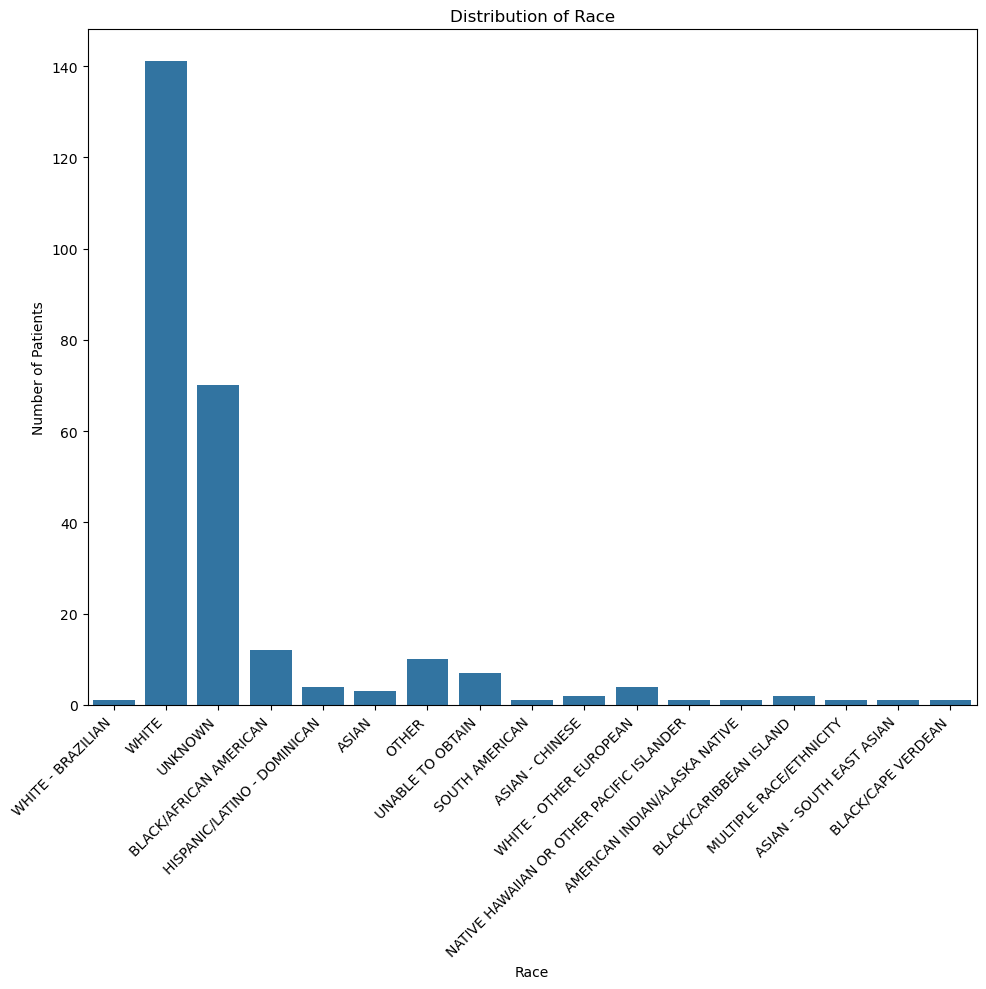

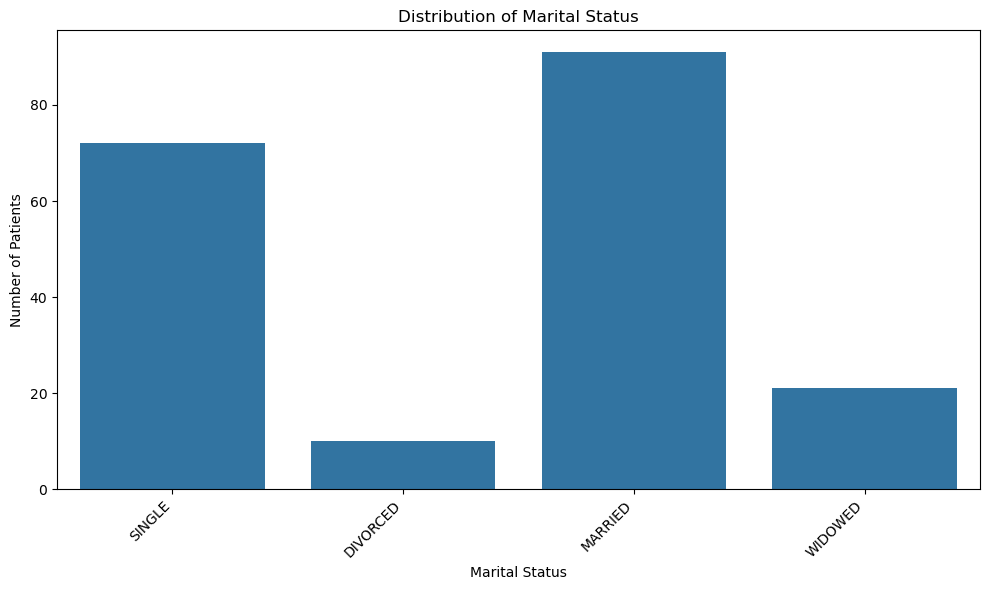

In [507]:

# Plotting the distribution of Race
plt.figure(figsize=(10, 10))
sns.countplot(data=unique_patients_icu, x='race' )
plt.title('Distribution of Race')
plt.xlabel('Race')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plotting the distribution of Marital Status
plt.figure(figsize=(10, 6))
sns.countplot(data=unique_patients_icu, x='marital_status' )
plt.title('Distribution of Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



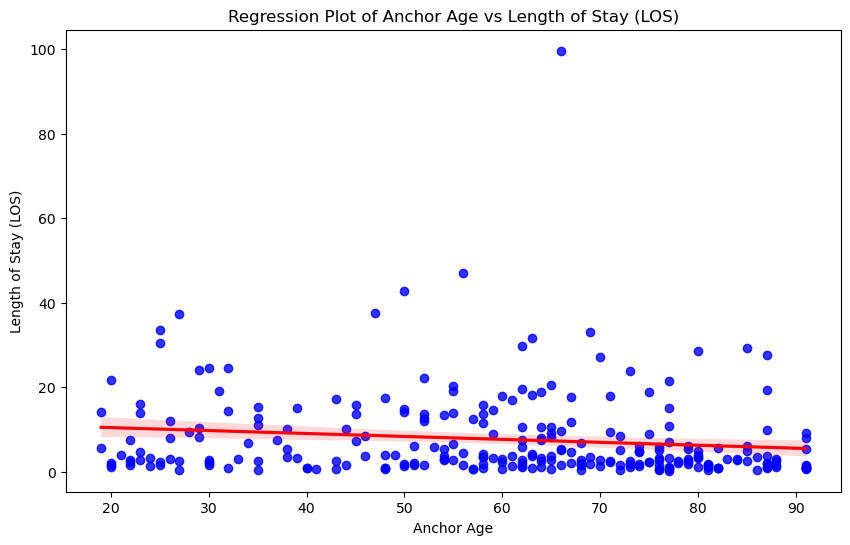

In [509]:
# Regression plot for Age vs LOS
plt.figure(figsize=(10, 6))
sns.regplot(data=unique_patients_icu, x='anchor_age', y='los', scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title('Regression Plot of Anchor Age vs Length of Stay (LOS)')
plt.xlabel('Anchor Age')
plt.ylabel('Length of Stay (LOS)')
plt.show()


# modeling for icu_stay1 (have to merge more dataset

In [117]:
outputevents=loading("mimic-iv-2.2/icu/outputevents.csv.gz")
print(outputevents.shape)
outputevents1 = outputevents[outputevents['subject_id'].isin(filtered_data1['subject_id'])]
outputevents1

(4234967, 9)


,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valueuom
4850,10010867,22429197,39880770,1195,2148-01-04 23:23:00,2148-01-04 23:24:00,226559,100.0,ml
4851,10010867,22429197,39880770,4915,2148-01-02 07:00:00,2148-01-02 08:02:00,226559,200.0,ml
4852,10010867,22429197,39880770,4915,2148-01-02 08:00:00,2148-01-02 07:49:00,226559,220.0,ml
4853,10010867,22429197,39880770,4915,2148-01-02 08:00:00,2148-01-02 07:50:00,226588,100.0,ml
4854,10010867,22429197,39880770,4915,2148-01-02 09:00:00,2148-01-02 09:39:00,226559,225.0,ml
...,...,...,...,...,...,...,...,...,...
4221865,19970947,28546800,33610703,41272,2183-08-04 13:20:00,2183-08-04 13:20:00,226559,2100.0,ml
4221866,19970947,28546800,33610703,41272,2183-08-04 16:00:00,2183-08-04 16:12:00,226559,75.0,ml
4221867,19970947,28546800,33610703,41272,2183-08-04 17:00:00,2183-08-04 17:07:00,226559,40.0,ml
4221868,19970947,28546800,33610703,41272,2183-08-04 18:00:00,2183-08-04 18:42:00,226559,30.0,ml


In [180]:
# # we filter the icu patient in the inputevents dataset from the icu section
# inputevents=loading("mimic-iv-2.2/icu/inputevents.csv.gz")
# print(inputevents.shape)
# inputevents1 = inputevents[inputevents['subject_id'].isin(filtered_data1['subject_id'])]
 
inputevents1=pd.read_csv('inputevents1.csv')
print(inputevents1.info())
inputevents1 = inputevents1[inputevents1['hadm_id'].isin(icu_stay1['hadm_id'])]
inputevents1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106928 entries, 0 to 106927
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   subject_id                     106928 non-null  int64  
 1   hadm_id                        106928 non-null  int64  
 2   stay_id                        106928 non-null  int64  
 3   caregiver_id                   106928 non-null  int64  
 4   starttime                      106928 non-null  object 
 5   endtime                        106928 non-null  object 
 6   storetime                      106928 non-null  object 
 7   itemid                         106928 non-null  int64  
 8   amount                         106928 non-null  float64
 9   amountuom                      106928 non-null  object 
 10  rate                           54261 non-null   float64
 11  rateuom                        54261 non-null   object 
 12  orderid                       

,subject_id,hadm_id,stay_id,caregiver_id,starttime,endtime,storetime,itemid,amount,amountuom,...,ordercomponenttypedescription,ordercategorydescription,patientweight,totalamount,totalamountuom,isopenbag,continueinnextdept,statusdescription,originalamount,originalrate
0,10010867,22429197,39880770,1195,2148-01-04 23:02:00,2148-01-05 01:32:00,2148-01-05 02:30:00,222168,906.000123,mg,...,Main order parameter,Continuous Med,120.0,100.0,ml,0,0,FinishedRunning,906.000122,50.434063
1,10010867,22429197,39880770,1195,2148-01-04 23:02:00,2148-01-05 01:32:00,2148-01-05 02:30:00,225943,90.599996,ml,...,Mixed solution,Continuous Med,120.0,100.0,ml,0,0,FinishedRunning,90.599998,36.239998
2,10010867,22429197,39880770,1195,2148-01-04 23:23:00,2148-01-04 23:24:00,2148-01-04 23:23:00,221833,1.000000,mg,...,Main order parameter,Drug Push,120.0,NaN,NaN,0,0,FinishedRunning,1.000000,1.000000
3,10010867,22429197,39880770,4915,2148-01-02 07:49:00,2148-01-02 08:24:00,2148-01-02 07:53:00,225150,55.999997,mcg,...,Main order parameter,Continuous Med,120.0,100.0,ml,0,0,ChangeDose/Rate,400.000000,0.800000
4,10010867,22429197,39880770,4915,2148-01-02 07:49:00,2148-01-02 08:24:00,2148-01-02 07:53:00,225158,14.000000,ml,...,Mixed solution,Continuous Med,120.0,100.0,ml,0,0,ChangeDose/Rate,100.000000,24.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106923,19970947,28546800,33610703,41272,2183-08-04 13:36:00,2183-08-04 21:00:00,2183-08-04 13:37:00,225166,12.595744,mEq,...,Additives ...,Continuous IV,50.0,1000.0,ml,0,0,Paused,20.000000,0.028369
106924,19970947,28546800,33610703,41272,2183-08-04 15:00:00,2183-08-04 15:01:00,2183-08-04 15:35:00,225907,1.000000,dose,...,Main order parameter,Drug Push,50.0,50.0,ml,0,0,FinishedRunning,1.000000,1.000000
106925,19970947,28546800,33610703,41272,2183-08-04 15:00:00,2183-08-04 15:01:00,2183-08-04 15:35:00,225943,50.000000,ml,...,Mixed solution,Drug Push,50.0,50.0,ml,0,0,FinishedRunning,50.000000,0.000000
106926,19970947,28546800,33610703,41272,2183-08-04 16:49:00,2183-08-04 16:50:00,2183-08-04 16:49:00,228315,1000.000000,mg,...,Main order parameter,Drug Push,50.0,NaN,NaN,0,0,FinishedRunning,1000.000000,999.999939


In [178]:
labevents1=pd.read_csv('filtered_labevents.csv')
labevents1= labevents1[labevents1['hadm_id'].isin(icu_stay1['hadm_id'])]

#merge with definition for lab item
lab_items=loading("mimic-iv-2.2/hosp/d_labitems.csv.gz")

labevents1=labevents1.merge(lab_items,on='itemid', how='left')
labevents1=labevents1[['hadm_id','itemid','label','flag']]
labevents1

,hadm_id,itemid,label,flag
0,22429197.0,50801,Alveolar-arterial Gradient,NaN
1,22429197.0,50802,Base Excess,NaN
2,22429197.0,50804,Calculated Total CO2,abnormal
3,22429197.0,50812,Intubated,NaN
4,22429197.0,50816,Oxygen,NaN
...,...,...,...,...
143240,28546800.0,50960,Magnesium,NaN
143241,28546800.0,50970,Phosphate,NaN
143242,28546800.0,50971,Potassium,NaN
143243,28546800.0,50983,Sodium,NaN


In [154]:
# Set the label column as the new columns and assign 0 for NaN and 1 for 
# abnormal based on the flag
labevents1_pivot = labevents1.pivot_table(index=['hadm_id'], \
        columns='label', values='flag', aggfunc=lambda x: 1 if 'abnormal' in x.values else 0)

labevents1_pivot = labevents1_pivot.fillna(0)

labevents1_pivot = labevents1_pivot.reset_index()
labevents1_pivot


label,hadm_id,% Hemoglobin A1c,25-OH Vitamin D,ARCH-1,Absolute Basophil Count,Absolute CD3 Count,Absolute CD4 Count,Absolute CD8 Count,Absolute Eosinophil Count,Absolute Lymphocyte Count,...,White Blood Cells,XUCU,Yeast,Young Cells,eAG,pCO2,pH,pO2,"proBNP, Pleural",tacroFK
0,20015722.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20322847.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
2,20351877.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
3,20432032.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
4,20456898.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,29893640.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
254,29894712.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
255,29897905.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
256,29930771.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [158]:
chartevents1=pd.read_csv('filtered_chartevents.csv')
chartevents1= chartevents1[chartevents1['hadm_id'].isin(icu_stay1['hadm_id'])]

#merge with d_item
d_items=loading("mimic-iv-2.2/icu/d_items.csv.gz")

chartevents1=chartevents1.merge(d_items,on='itemid', how='left')
chartevents1=chartevents1[['hadm_id','itemid','abbreviation','warning']]
chartevents1

,hadm_id,itemid,abbreviation,warning
0,22429197,220045,HR,0.0
1,22429197,220048,Heart Rhythm,0.0
2,22429197,220050,ABPs,0.0
3,22429197,220051,ABPd,0.0
4,22429197,220052,ABPm,0.0
...,...,...,...,...
3371558,28546800,225625,Calcium non-ionized,0.0
3371559,28546800,225677,Phosphorous,0.0
3371560,28546800,227073,Anion gap,0.0
3371561,28546800,227442,Potassium (serum),0.0


In [159]:
#similarly, change it to pivot
chartevents1_pivot = chartevents1.pivot_table(
    index=['hadm_id'], columns='abbreviation', values='warning', 
    aggfunc=lambda x: 1 if 'warning' in x.values else 0)

 
chartevents1_pivot = chartevents1_pivot.fillna(0)
chartevents1_pivot = chartevents1_pivot.reset_index()

chartevents1_pivot


abbreviation,hadm_id,% Minute Volume,14 G Infiltration Scale,14 G Phlebitis Scale,14 Gauge Dressing Occlusive,14 Gauge Reason Discontinued,14 Gauge Site Appear,14 Gauge placed in outside facility,14 Gauge placed in the field,16 G Infiltration Scale,...,Vital Cap,Vocalization,Vocalization-Post,Vti High,WBC,WBCApacheIIValue,Warming Device,Warming Device Status,WbcApacheIIScore,Yawning
0,20015722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20322847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20327393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20351877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20432032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,29893640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
260,29894712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
261,29897905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
262,29930771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [531]:
## Merge everything to icu_stay1
final=unique_admission_icu.copy()
merged_spinal_chartevents = final.merge(chartevents1_pivot, on='hadm_id', how='left')


final = merged_spinal_chartevents.merge(labevents1_pivot, on='hadm_id', how='left')

final = merged_spinal_chartevents.merge(final_df, on=['hadm_id','subject_id'], how='left')
final = final.fillna(0)

final
# #since a lot of unknown race, we drop it
final = final.drop(columns=['anchor_age', 'anchor_year', 'anchor_year_group', 'subject_id',
                    'race', 'icd_code', 'long_title', 'hadm_id','icd_group'])

# # One-hot encode for those predictors
final = pd.get_dummies(final, columns=['marital_status','gender','admission_type'],\
                          prefix=['marital','gender','ad_type'])

print(final.info())
final

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Columns: 1601 entries, los to ad_type_URGENT
dtypes: bool(13), float64(1588)
memory usage: 3.2 MB
None


los  ed_duration_hours  % Minute Volume  14 G Infiltration Scale  \
0     9.362049           2.800000              0.0                      0.0   
1    19.141736          13.066667              0.0                      0.0   
2    19.200208           3.183333              0.0                      0.0   
3     6.130926           3.666667              0.0                      0.0   
4     1.442708          52.016667              0.0                      0.0   
..         ...                ...              ...                      ...   
259   4.686898           2.600000              0.0                      0.0   
260   4.001019           1.966667              0.0                      0.0   
261  15.409421           2.000000              0.0                      0.0   
262   3.750405           2.483333              0.0                      0.0   
263   1.336933           8.833333              0.0                      0.0   

     14 G Phlebitis Scale  14 Gauge Dressing Occlusive  \
0                     0.0                          0.0   
1                     0.0                          0.0   
2                     0.0                          0.0   
3                     0.0                          0.0   
4                     0.0                          0.0   
..                    ...                          ...   
259                   0.0                          0.0   
260                   0.0                          0.0   
261                   0.0                          0.0   
262                   0.0                          0.0   
263                   0.0                          0.0   

     14 Gauge Reason Discontinued  14 Gauge Site Appear  \
0                             0.0                   0.0   
1                             0.0                   0.0   
2                             0.0                   0.0   
3                             0.0                   0.0   
4                             0.0                   0.0   
..                            ...                   ...   
259                           0.0                   0.0   
260                           0.0                   0.0   
261                           0.0                   0.0   
262                           0.0                   0.0   
263                           0.0                   0.0   

     14 Gauge placed in outside facility  14 Gauge placed in the field  \
0                                    0.0                           0.0   
1                                    0.0                           0.0   
2                                    0.0                           0.0   
3                                    0.0                           0.0   
4                                    0.0                           0.0   
..                                   ...                           ...   
259                                  0.0                           0.0   
260                                  0.0                           0.0   
261                                  0.0                           0.0   
262                                  0.0                           0.0   
263                                  0.0                           0.0   

     16 G Infiltration Scale  16 G Phlebitis Scale  \
0                        0.0                   0.0   
1                        0.0                   0.0   
2                        0.0                   0.0   
3                        0.0                   0.0   
4                        0.0                   0.0   
..                       ...                   ...   
259                      0.0                   0.0   
260                      0.0                   0.0   
261                      0.0                   0.0   
262                      0.0                   0.0   
263                      0.0                   0.0   

     16 Gauge Dressing Occlusive  16 Gauge Reason Discontinued  \
0                            0.0                    

count    264.000000
mean       7.735766
std       10.243493
min        0.228808
25%        1.665828
50%        3.513582
75%       10.446508
max       99.638449
Name: los, dtype: float64


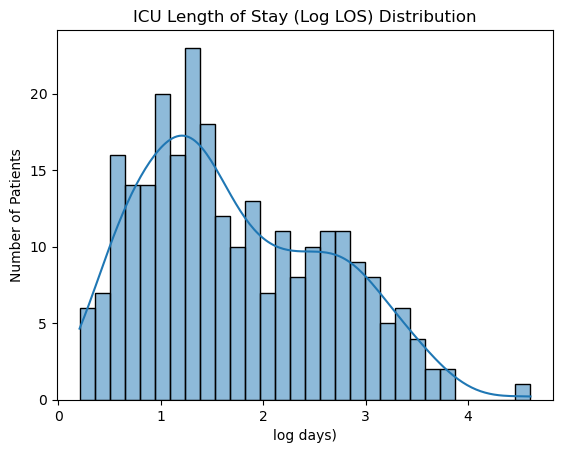

count    264.000000
mean       1.721165
std        0.906757
min        0.206044
25%        0.980514
50%        1.507090
75%        2.437682
max        4.611534
Name: los_log, dtype: float64

In [687]:

final=pd.read_csv('final.csv')

# there are some outliers  (eg: los 99 days) so we want to minimize it 
print(final['los'].describe())
  


#we want to apply log los to mitigate the effects of outlier
final['los_log'] = np.log(final['los'] + 1)
sns.histplot(final['los_log'], bins=30, kde=True)
plt.title('ICU Length of Stay (Log LOS) Distribution')
plt.xlabel('log days)')
plt.ylabel('Number of Patients')
plt.show()
 

final['los_log'].describe()



In [673]:
#data augmentation to doube the size of the datset from 264 to 528

# Add noise to the continuous column 'ed_duration_hours'
continuous_col = 'ed_duration_hours'
noise = np.random.normal(0, 0.05 * final[continuous_col].std(), size=len(final))  # 5% noise
final[continuous_col] = final[continuous_col] + noise

# The binary columns will remain unchanged

# so final dataset will be 
augmented = final.copy()
final_augmented = pd.concat([final, augmented], ignore_index=True)
final_augmented

los  ed_duration_hours  % Minute Volume  14 G Infiltration Scale  \
0     9.362049           3.076988              0.0                      0.0   
1    19.141736          12.994503              0.0                      0.0   
2    19.200208           3.154141              0.0                      0.0   
3     6.130926           4.131297              0.0                      0.0   
4     1.442708          52.382957              0.0                      0.0   
..         ...                ...              ...                      ...   
523   4.686898           2.787928              0.0                      0.0   
524   4.001019           1.570729              0.0                      0.0   
525  15.409421           2.190442              0.0                      0.0   
526   3.750405           1.664219              0.0                      0.0   
527   1.336933           9.017507              0.0                      0.0   

     14 G Phlebitis Scale  14 Gauge Dressing Occlusive  \
0                     0.0                          0.0   
1                     0.0                          0.0   
2                     0.0                          0.0   
3                     0.0                          0.0   
4                     0.0                          0.0   
..                    ...                          ...   
523                   0.0                          0.0   
524                   0.0                          0.0   
525                   0.0                          0.0   
526                   0.0                          0.0   
527                   0.0                          0.0   

     14 Gauge Reason Discontinued  14 Gauge Site Appear  \
0                             0.0                   0.0   
1                             0.0                   0.0   
2                             0.0                   0.0   
3                             0.0                   0.0   
4                             0.0                   0.0   
..                            ...                   ...   
523                           0.0                   0.0   
524                           0.0                   0.0   
525                           0.0                   0.0   
526                           0.0                   0.0   
527                           0.0                   0.0   

     14 Gauge placed in outside facility  14 Gauge placed in the field  \
0                                    0.0                           0.0   
1                                    0.0                           0.0   
2                                    0.0                           0.0   
3                                    0.0                           0.0   
4                                    0.0                           0.0   
..                                   ...                           ...   
523                                  0.0                           0.0   
524                                  0.0                           0.0   
525                                  0.0                           0.0   
526                                  0.0                           0.0   
527                                  0.0                           0.0   

     16 G Infiltration Scale  16 G Phlebitis Scale  \
0                        0.0                   0.0   
1                        0.0                   0.0   
2                        0.0                   0.0   
3                        0.0                   0.0   
4                        0.0                   0.0   
..                       ...                   ...   
523                      0.0                   0.0   
524                      0.0                   0.0   
525                      0.0                   0.0   
526                      0.0                   0.0   
527                      0.0                   0.0   

     16 Gauge Dressing Occlusive  16 Gauge Reason Discontinued  \
0                            0.0                    

Method use: XGBoost

Tree-based model: XGBoost uses decision trees as base learners and employs a gradient boosting framework to combine them. It builds multiple trees sequentially, with each new tree trying to correct the errors (residuals) made by the previous ones.

Gradient Boosting: This technique builds an ensemble of trees by adding one tree at a time. Each new tree helps to minimize the residual errors of the previous tree, gradually improving the model.

Non-linear relationships: Since decision trees are capable of modeling non-linear relationships in the data, XGBoost is well-suited for tasks where the relationships between features and the target variable are non-linear.

Why use?

Captures non-linear relationships: Handles complex, non-linear patterns in data.

Robust to outliers: Not heavily influenced by extreme values in the data.

Regularization: Prevents overfitting through L1 and L2 regularization.

Performance: Often delivers strong predictive accuracy, especially with complex datasets.

Feature importance: Provides insights into which features are most important for predictions.

Handles imbalanced data: Works well even when the target variable is skewed or imbalanced.

In [723]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
 
# (log LOS)
# Features and target  
X = final_augmented.drop(columns=['los_log','los'])
y = final_augmented['los_log']

# Initialize XGBoost regressor
model = XGBRegressor( 
    n_estimators=100,  max_depth=4,  learning_rate=0.1,  random_state=42,
    n_jobs=-1)
# 0.1 – Slower learning → better generalization  
# 4 – Lower depth → less risk of overfitting

# cross-validation for R²
r2_scores = cross_val_score(model, X, y, cv=10, scoring='r2')

# Cross-validation for RMSE 
neg_mse_scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-neg_mse_scores)
 
print("R² scores for each fold (log LOS):", r2_scores)
print("Average R² score:", np.mean(r2_scores))
print("XGBoost RMSE scores (log LOS):", rmse_scores)
print("Average RMSE score:", rmse_scores.mean())



R² scores for each fold (log LOS): [0.60901355 0.51777725 0.50375488 0.42925344 0.55437696 0.56894368
 0.49429601 0.50192534 0.45267467 0.55110986]
Average R² score: 0.5183125628091134
XGBoost RMSE scores (log LOS): [0.61886704 0.64655282 0.58563288 0.64885425 0.5839691  0.6551077
 0.65761838 0.58387802 0.64030425 0.58810908]
Average RMSE score: 0.6208893546677631


R² Interpretation:
The average R² score for the model is 0.518, which means that the model can explain approximately 51.8% of the variance in the log-transformed LOS. This is considered a moderate score. While it indicates that the model captures a fair amount of the variability in LOS, it also shows there is still significant unexplained variance, suggesting there is room for improvement. A higher R² value closer to 1.0 would indicate better model performance, so future improvements in the model could aim to increase this score through better feature engineering, hyperparameter tuning, or exploring other models.

RMSE Interpretation:
The average RMSE score of the model is 0.62, which represents the average error between the predicted and actual log-transformed LOS values. When back-transformed to the original LOS scale, this corresponds to an error of about 1.8 days.

Given that the length of stay in hospitals can range widely (and the small siz of dataset), an error of around 1.8 days could be acceptable in many contexts. However, depending on the application and the required precision, this level of error may need improvement

Concerns:

The model’s performance could be influenced by the size and diversity of the dataset. With only 264 rows and about 1,600 columns, the dataset may not be large enough to capture the full complexity of patient Length of Stay (LOS), especially in a highly variable context like hospital stays. Although data augmentation is used, with only slight changes to one continuous variable to double the dataset size, this approach might not sufficiently address the variability in patient data.

Additionally, the model's score remains low, and it does not account for patients who have multiple diseases simultaneously. While we already filter all diagnoses and categorize them as 'other_icd', we have found that it is quite challenging for the model to expand to include additional predictors. Our group will work towards finding a solution to make the model behave differently when a patient has multiple diagnoses. This is important because the more diagnoses a patient has, the more likely they are to require a longer LOS.

